In [39]:
import tensorflow as tf
import cv2
import sys
import numpy as np
#from tensorflow.keras.applications.resnet50 import preprocess_input
from efficientnet.tfkeras import EfficientNetB0, preprocess_input
import pandas as pd
import os
from PIL import Image
import glob
import xml.etree.ElementTree as ET
from xml.dom import minidom
import matplotlib.pyplot as plt
#import efficientnet.tfkeras
from tensorflow.keras.models import load_model

In [22]:
def crop_image(image, boxes, save_path, resize=None):
        #seed_image = Image.open(os.listdir('./imgs')[0])
        seed_image = Image.open(image)
        images = list(map(lambda b : seed_image.crop(b), boxes))
        if str(type(resize)) == "<class 'tuple'>":
            images = list(map(lambda i : i.resize(resize), images))
        num = 0
        
        for img in images:
            num = num + 1
            img.save('{}/{}.jpg'.format(save_path, num))
            

def get_boxes(label_path):
    label_path = label_path
    xml_list = os.listdir(label_path)

    boxes_1 = {}
    cnt = 0
    for xml_file in sorted(xml_list):
        if xml_file =='.DS_Store':
            pass
        else:
                #try:
            xml_path = os.path.join(label_path,xml_file)

            root_1 = minidom.parse(xml_path)
            bnd_1 = root_1.getElementsByTagName('bndbox')

            result = []
            for i in range(len(bnd_1)):
                xmin = int(bnd_1[i].childNodes[1].childNodes[0].nodeValue)
                ymin = int(bnd_1[i].childNodes[3].childNodes[0].nodeValue)
                xmax = int(bnd_1[i].childNodes[5].childNodes[0].nodeValue)
                ymax = int(bnd_1[i].childNodes[7].childNodes[0].nodeValue)
                result.append((xmin,ymin,xmax,ymax))

            boxes_1[str(cnt)] = result
            cnt += 1
    
    return boxes_1

In [5]:
save_path = './data'
num = 1
'{}/{}.jpg'.format(save_path, num)

'./data/1.jpg'

In [93]:
#### 
df = pd.read_csv('./labels_1.txt', sep = ' ', index_col=False, header=None)
CLASS_NAMES = df[0].tolist()
CLASS_NAMES = sorted(CLASS_NAMES)

df = pd.read_csv('./labels_binary.txt', sep = ' ', index_col=False, header=None)
EM_CLASS_NAMES = df[0].tolist()
EM_CLASS_NAMES = sorted(EM_CLASS_NAMES)

print(CLASS_NAMES)
print(EM_CLASS_NAMES)

#model = tf.keras.models.load_model('./model/beverage.h5')
empty_model = tf.keras.models.load_model('./1.model/efn_binary_empty.h5')
main_model = tf.keras.models.load_model('./1.model/em24.h5')


['2%_can', '2%_peach_pet', 'aloe_pet', 'bongbong_can', 'coca_can', 'coca_pet', 'dailyC_pet', 'demisoda_can', 'fantaorange_pet', 'fantapine_pet', 'galbae_can', 'galbae_pet', 'hwal_pet', 'jeju_pet', 'lemonade_pet', 'mango_can', 'mccol_pet', 'milkis_can', 'milkis_pet', 'mogumogu_pet', 'morning_pet', 'oranC_can', 'peach_can', 'pepsi_can', 'pepsi_pet', 'pocari_can', 'power_can', 'redbull_can', 'sol_can', 'sprite_can', 'sprite_pet', 'tejava_can', 'vilak_pet', 'vita500_pet', 'welchs_can']
['empty', 'product']


In [90]:
img_num = 0

em_boxes = get_boxes('./4.xml_empty')['0']
main_boxes = get_boxes('./4.xml')['0']


crop_image('./2.seed_img/' + os.listdir('./2.seed_img')[img_num], 
           em_boxes, 
           './3.empty_imgs',
           (224,224))

crop_image('./2.seed_img/' + os.listdir('./2.seed_img')[img_num], 
           main_boxes, 
           './3.cls_imgs',
           (224,224))

empty_img_path = sorted(glob.glob('./3.empty_imgs/*'))
main_img_path = sorted(glob.glob('./3.cls_imgs/*'))

empty_result = []
for image in empty_img_path:
        file_info = image.split('/')[-2]

        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = cv2.resize(image, (IMG_RESIZE, IMG_RESIZE))

        image = np.expand_dims(image, axis=0)
        image = preprocess_input(image)
        predictions = empty_model.predict(image, steps=1)
        score = np.argmax(predictions[0])
        
        empty_result.append(EM_CLASS_NAMES[score])
        
        #print('predict result : ', EM_CLASS_NAMES[score], predictions[0][score])


main_result = []
for image in main_img_path:
        file_info = image.split('/')[-2]

        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = cv2.resize(image, (IMG_RESIZE, IMG_RESIZE))

        image = np.expand_dims(image, axis=0)
        image = preprocess_input(image)
        predictions = main_model.predict(image, steps=1)
        score = np.argmax(predictions[0])
        
        main_result.append(CLASS_NAMES[score])
        
        #print('predict result : ', CLASS_NAMES[score], predictions[0][score])

final_result = [i if i == 'empty' else j for i,j in zip(empty_result, main_result)]
pd.DataFrame(final_result).T

,0,1,2,3,4,5,6,7
0,hwal_pet,galbae_can,peach_can,bongbong_can,mango_can,vita500_pet,dailyC_pet,dailyC_pet


['hwal_pet', 'galbae_can', 'peach_can', 'bongbong_can', 'mango_can', 'vita500_pet', 'dailyC_pet', 'dailyC_pet']


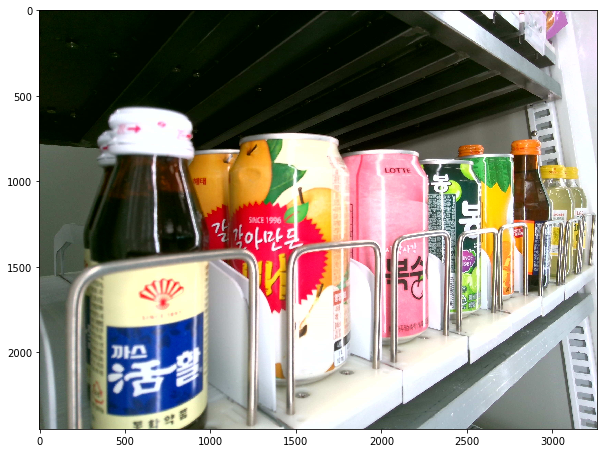

In [91]:
plt.figure(figsize=(10, 10))
im = cv2.imread('./2.seed_img/' + os.listdir('./2.seed_img')[img_num])
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
print(final_result)
plt.imshow(im)

In [34]:
final_result

['vita500_pet',
 'empty',
 'dailyC_pet',
 'hwal_pet',
 'galbae_can',
 'peach_can',
 'bongbong_can',
 'mango_can']

In [98]:
empty_img_list = sorted(glob.glob('./3.empty_imgs/*'))
main_img_list = sorted(glob.glob('./3.cls_imgs/*'))

def infer(cropped_image_list, model_name, class_file):
    result = []
    for image in cropped_image_list:
        file_info = image.split('/')[-2]

        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = cv2.resize(image, (IMG_RESIZE, IMG_RESIZE))

        image = np.expand_dims(image, axis=0)
        image = preprocess_input(image)
        predictions = model_name.predict(image, steps=1)
        score = np.argmax(predictions[0])
        
        result.append(class_file[score])
        
    return result

In [99]:
empty_result = infer(cropped_image_list = empty_img_list, model_name = empty_model, class_file=EM_CLASS_NAMES)
main_result = infer(cropped_image_list = main_img_list, model_name = main_model, class_file=CLASS_NAMES)

final_result = [i if i == 'empty' else j for i,j in zip(empty_result, main_result)]
pd.DataFrame(final_result).T

,0,1,2,3,4,5,6,7
0,hwal_pet,galbae_can,peach_can,bongbong_can,mango_can,vita500_pet,dailyC_pet,dailyC_pet


In [12]:

empty_result = []
for image in empty_img_path:
        file_info = image.split('/')[-2]

        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = cv2.resize(image, (IMG_RESIZE, IMG_RESIZE))

        image = np.expand_dims(image, axis=0)
        image = preprocess_input(image)
        predictions = empty_model.predict(image, steps=1)
        score = np.argmax(predictions[0])
        
        empty_result.append(EM_CLASS_NAMES[score])
        
        #print('predict result : ', EM_CLASS_NAMES[score], predictions[0][score])


main_result = []
for image in main_img_path:
        file_info = image.split('/')[-2]

        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = cv2.resize(image, (IMG_RESIZE, IMG_RESIZE))

        image = np.expand_dims(image, axis=0)
        image = preprocess_input(image)
        predictions = main_model.predict(image, steps=1)
        score = np.argmax(predictions[0])
        
        main_result.append(CLASS_NAMES[score])
        
        #print('predict result : ', CLASS_NAMES[score], predictions[0][score])
